100%|██████████| 6/6 [00:42<00:00,  7.14s/it]
/Users/chenhao/Downloads/Anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenhao/Downloads/Anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenhao/Downloads/Anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 30334 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenhao/Downloads/Anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 19975 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenhao/Downloads/Anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph

  trade_date          rzye       circ_mv   ratio
5 2025-07-30  1.964255e+12  8.659355e+17  2.2684
4 2025-07-31  1.964698e+12  8.551648e+17  2.2974
3 2025-08-01  1.960040e+12  8.534035e+17  2.2967
2 2025-08-04  1.971361e+12  8.529838e+17  2.3111
1 2025-08-05  1.980090e+12  8.611262e+17  2.2994
0 2025-08-06  0.000000e+00  0.000000e+00     NaN


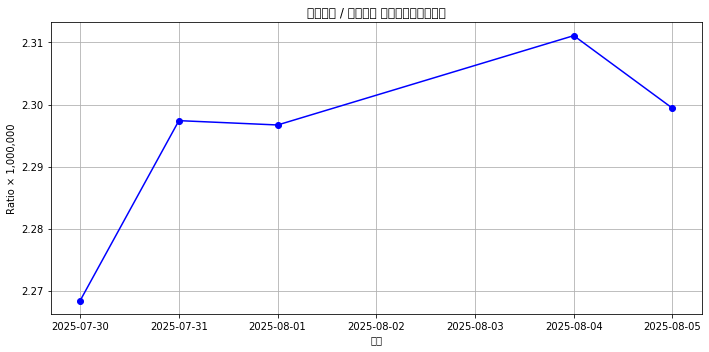

In [12]:
import tushare as ts
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设置 token
ts.set_token('ea24e41b49e17e308180bdea2ee1e01dae876505975ee8c7ebd279d3')  # 替换为你的实际 Token
pro = ts.pro_api()

# 近3天范围，取过去7天范围内所有交易日
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=7)
start_str = start_date.strftime('%Y%m%d')
end_str = end_date.strftime('%Y%m%d')

trade_cal = pro.trade_cal(exchange='SSE', start_date=start_str, end_date=end_str)
trade_dates = trade_cal[trade_cal['is_open'] == 1]['cal_date'].tolist()

results = []

for trade_date in tqdm(trade_dates):
    try:
        margin_sse = pro.margin(trade_date=trade_date, exchange_id='SSE')
        margin_szse = pro.margin(trade_date=trade_date, exchange_id='SZSE')
        rzye_total = (
            (margin_sse['rzye'].sum() if not margin_sse.empty else 0) +
            (margin_szse['rzye'].sum() if not margin_szse.empty else 0)
        )

        daily_mv = pro.daily_basic(trade_date=trade_date, fields='ts_code,circ_mv')
        total_circ_mv = daily_mv['circ_mv'].sum() * 1e8 if not daily_mv.empty else 0  # 亿转元

        ratio = (rzye_total / total_circ_mv) * 1_000_000 if total_circ_mv > 0 else None  # 百万倍放大

        results.append({
            'trade_date': trade_date,
            'rzye': round(rzye_total, 2),
            'circ_mv': round(total_circ_mv, 2),
            'ratio': round(ratio, 4) if ratio is not None else None
        })

        time.sleep(0.4)
    except Exception as e:
        print(f"{trade_date} 出错: {e}")
        time.sleep(3)

df = pd.DataFrame(results)
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.sort_values('trade_date', inplace=True)

print(df)

# 画图
plt.figure(figsize=(10, 5))
plt.plot(df['trade_date'], df['ratio'], marker='o', linestyle='-', color='b')
plt.title('融资余额 / 流通市值 比例（百万倍放大）')
plt.xlabel('日期')
plt.ylabel('Ratio × 1,000,000')
plt.grid(True)
plt.tight_layout()
plt.show()
